In [139]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import isfile, join
import pandas as pd
import pickle

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from scipy.cluster.vq import kmeans, vq

In [2]:
def open_pic(path):
    return cv2.imread(path)

image_name = '2HULL_PELENG_D_A_000.png'
my_pic = open_pic(f'archive/pics/{image_name}')

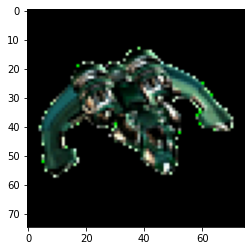

In [3]:
plt.imshow(my_pic)

## Feature Extraction using SIFT

[[104.  65.   0. ...  14.   5.  16.]
 [  9.   0.   0. ...   2.  10.  60.]
 [  2.   0.   0. ...   1.   0.   0.]
 ...
 [ 37.  27.   5. ...   0.   5.  16.]
 [ 74.  14.   5. ...   0.   0.   1.]
 [ 14.   0.   0. ...  11.   9.  10.]]


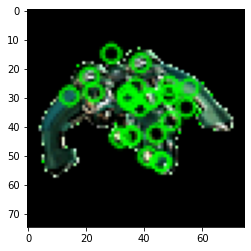

In [4]:
my_pic = cv2.imread(f'archive/pics/{image_name}')
sift = cv2.SIFT_create()
train_keypoints, descriptors = sift.detectAndCompute(my_pic, None)
keypoints = np.copy(my_pic)
sift_image = cv2.drawKeypoints(my_pic, train_keypoints, keypoints, color = (0, 255, 0))
plt.imshow(sift_image)
print(descriptors)

## Function for plotting keypoints

In [5]:
my_pic = cv2.imread(f'archive/pics/{image_name}')

def get_orb_points(img):
    orb = cv2.ORB_create()
    train_keypoints, train_descriptor = orb.detectAndCompute(img, None)
    return train_descriptor


def get_sift_points(img):
    sift = cv2.SIFT_create()
    train_keypoints, descriptors = sift.detectAndCompute(img, None)
    return descriptors

In [6]:
my_pic = cv2.imread(f'archive/pics/{image_name}')
get_sift_points(my_pic)

array([[104.,  65.,   0., ...,  14.,   5.,  16.],
       [  9.,   0.,   0., ...,   2.,  10.,  60.],
       [  2.,   0.,   0., ...,   1.,   0.,   0.],
       ...,
       [ 37.,  27.,   5., ...,   0.,   5.,  16.],
       [ 74.,  14.,   5., ...,   0.,   0.,   1.],
       [ 14.,   0.,   0., ...,  11.,   9.,  10.]], dtype=float32)

## Appending descriptors of the training images in list

In [7]:
path_to_pics = 'archive/pics/output'
files = [f for f in listdir(path_to_pics) if isfile(join(path_to_pics, f))]

In [8]:
def get_class(s):
    if 'CARGOHOOK' in s:
        return 1 
    if 'DEFGENERATOR' in s:
        return 2 
    if 'ENGINE' in s:
        return 3 
    if 'FUELTANK' in s:
        return 4 
    if 'HULL' in s:
        return 5 
    if 'RADAR' in s:
        return 6
    if 'REPAIRROBOT' in s:
        return 7
    if 'CANER' in s:
        return 8
    if 'W' in s:
        return 9
    else:
        print(s)


In [9]:
df = pd.DataFrame()

df['file_name'] = files
df['file_name_short'] = [file[len('pics_original_'):file.find('.png') + 4] for file in files]
df['class'] = df['file_name_short'].apply(lambda x: get_class(x))


df.head()

,file_name,file_name_short,class
0,pics_original_2CARGOHOOK4A_000.png_07123620-44...,2CARGOHOOK4A_000.png,1
1,pics_original_2ENGINE1A_000.png_bfa8e5d4-e05c-...,2ENGINE1A_000.png,3
2,pics_original_2CARGOHOOK14A_033.png_a53743a4-8...,2CARGOHOOK14A_033.png,1
3,pics_original_2RADAR4A_000.png_44f78586-1975-4...,2RADAR4A_000.png,6
4,pics_original_2SCANER3A_023.png_f2c5138b-92e4-...,2SCANER3A_023.png,8


<AxesSubplot:>

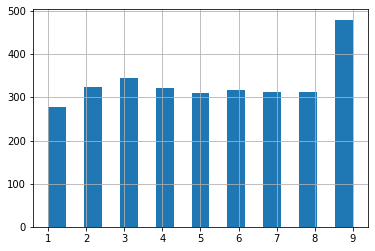

In [10]:
df['class'].hist(bins=17)

In [137]:
df['class'].value_counts()

9    480
3    345
2    325
4    322
6    317
8    312
7    312
5    310
1    277
Name: class, dtype: int64

In [117]:
df = shuffle(df)
y = df['class']
X = df['file_name']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)

In [118]:
X_test.shape, X_train.shape


((750,), (2250,))

## Extract features on `train` data

In [119]:
data = []
for file in X_train:
    if len(data) == 0:
        data = get_sift_points(cv2.imread(f'archive/pics/output/{file}'))
    else:
        data = np.vstack((data,get_sift_points(cv2.imread(f'archive/pics/output/{file}'))))

In [120]:
data.shape

(149318, 128)

In [56]:

with open('BOW_train.pickle', 'wb') as handle:
    pickle.dump(data, handle)
    
    
# with open('BOW_train.pickle', 'rb') as handle:
#     data = pickle.load(handle)

In [121]:
data_float = data.astype(float)

## Performing K Means clustering on Descriptors

In [122]:
k = 500
voc, variance = kmeans(data_float, k, 1)

In [114]:
with open('voc_model.pickle', 'wb') as handle:
    pickle.dump(voc, handle)
    
# with open('voc_model.pickle', 'rb') as handle:
#     voc = pickle.load(handle)

## Creating histogram of training image

In [123]:
im_features = np.zeros((len(X_train), k), "float32")

for i, file in enumerate(X_train):
    words, distance = vq(get_sift_points(cv2.imread(f'archive/pics/output/{file}')), voc)
    for w in words:
        im_features[i][w] += 1

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

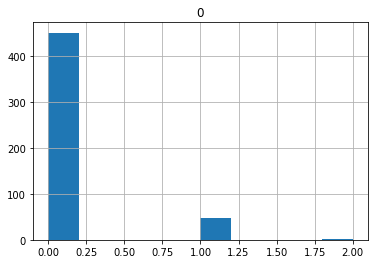

In [124]:
pd.DataFrame(im_features[11]).hist()

## Applying standardisation on training feature

In [125]:
from sklearn.preprocessing import StandardScaler


stdslr = StandardScaler().fit(im_features)
im_features = stdslr.transform(im_features)

## Creating Classification Model with SVM

In [126]:
from sklearn.svm import LinearSVC


clf = LinearSVC(max_iter = 80000)
clf.fit(im_features, np.array(y_train))

LinearSVC(max_iter=80000)

## Testing the Classification Model

#### On train data:

In [140]:
accuracy_score(clf.predict(im_features), y_train)

1.0

#### On test data:

In [128]:
test_features = np.zeros((len(X_test), k), "float32")

for i, file in enumerate(X_test):
    words, distance = vq(get_sift_points(cv2.imread(f'archive/pics/output/{file}')), voc)
    for w in words:
        test_features[i][w] += 1

In [129]:
test_features = stdslr.transform(test_features)

In [130]:
predict_classes = clf.predict(test_features)

In [141]:
accuracy_score(predict_classes, y_test)

0.8893333333333333

## Calibrated SVM

In [132]:
from sklearn.calibration import CalibratedClassifierCV

calibratedSVM = CalibratedClassifierCV(clf).fit(im_features, np.array(y_train))

In [134]:
ans = [np.argmax(i) + 1 for i in calibratedSVM.predict_proba(test_features)]

In [144]:
accuracy_score(predict_classes, y_test), '->', accuracy_score(y_test, ans)

(0.8893333333333333, '->', 0.9346666666666666)